In [1]:
import itertools
import functools
import collections
import random
import re
import glob
import math
import os
import json
import pickle

import pyranges as pr

#os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

#import joblib
import gzip
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
import scipy
from scipy.special import loggamma
from scipy.special import expit, logit
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import seaborn as sns
import statannot
import plotnine as p9
import sklearn
from sklearn import ensemble
from sklearn import pipeline
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import tensorflow_hub as hub
import tensorflow as tf
# Make sure the GPU is enabled 
assert tf.config.list_physical_devices('GPU')

2023-02-05 14:52:04.656554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 14:52:04.883586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 14:52:04.884369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
from Code.Utilities.seq_utils import one_hot_encode, rev_comp_sequence, rev_comp_one_hot, compute_offset_to_center_landmark
from Code.Utilities.enformer_utils import *

import Code.Utilities.basenji2_utils as basenji2_utils
import Code.Utilities.basenji1_utils as basenji1_utils
import kipoi

In [4]:
transform_path = 'gs://dm-enformer/models/enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'
model_path = 'https://tfhub.dev/deepmind/enformer/1'
fasta_file = 'Data/Genome/genome.fa'
fasta_file_hg19 = 'Data/Genome/genome_hg19.fa'
gtf_file = 'Data/Genome/genes.gtf'

In [5]:
# import target df
target_df = pd.read_csv("Data/Targets/targets.tsv",sep="\t")
target_df_basenji1 = pd.read_csv("Models/Basenji/basenji1_targets.txt",sep="\t", names=["identifier","file","description"])
print("done")

# import gtf
gtf_df = pr.read_gtf(gtf_file)

done


In [6]:
base_path_data = "Data/GTEX/"
base_path_data_kaessmann = "Data/Kaessmann/"
base_path_data_gtex_fc = "Data/gtex_aFC/"
base_path_data_tss_sim = "Data/TSS_sim/"
base_path_data_fulco = "Data/Fulco_CRISPRi/"
base_path_results = "Results/TSS_sim/"
base_path_results_xpresso = "Results/TSS_Xpresso/"
base_path_results_gtex_fc = "Results/gtex_aFC/"

# Load GTEX data

In [7]:
# load gtex data
gtex_df = (pd.read_csv(base_path_data + "GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct", sep="\t")
           .rename(columns={'Name':'gene_id','Description':'gene_name'})
          )
tissues = gtex_df.keys()[2:]
gtex_df = gtex_df.loc[~gtex_df.gene_id.str.endswith("PAR_Y")]
gtex_molten = gtex_df.melt(id_vars=['gene_id','gene_name'], var_name="tissue", value_name='observed_tpm')
gtex_molten['gene_id'] = gtex_molten['gene_id'].apply(lambda x: x.split('.')[0])

# remove genes which are never expressed (otherwise removing colMean will create phantom deviation for these)
nonexpressed_genes = set(gtex_molten.groupby('gene_id')["observed_tpm"].max().reset_index().query('observed_tpm == 0')["gene_id"])
gtex_molten = gtex_molten.query('gene_id not in @nonexpressed_genes')

In [8]:
# load kaessmann data
kaessmann_df = (pd.read_csv(base_path_data_kaessmann + "Human.RPKM.txt", sep=" ")
                .reset_index()
           .rename(columns={'index':'gene_id'})
          )
dev_tissues = kaessmann_df.keys()[1:]
kaessmann_molten = kaessmann_df.melt(id_vars=['gene_id'], var_name="sample", value_name='observed_tpm')
kaessmann_molten['gene_id'] = kaessmann_molten['gene_id'].apply(lambda x: x.split('.')[0])

# remove genes which are never expressed (otherwise removing colMean will create phantom deviation for these)
nonexpressed_genes = (kaessmann_molten.groupby('gene_id')["observed_tpm"].max().reset_index().query('observed_tpm == 0')["gene_id"])
kaessmann_molten = kaessmann_molten.query('gene_id not in @nonexpressed_genes')

In [9]:
test_set = pd.read_csv(base_path_data + "human_regions.bed", names=["Chromosome","Start","End","set"], sep="\t").query('set == "test"')

In [10]:
length_df = gtf_df.df.query('Feature == "exon"')
length_df["len"] = length_df["End"] - length_df["Start"]
length_df = length_df.groupby(['gene_id','transcript_id'])['len'].sum().reset_index()
length_df = length_df.groupby(['gene_id'])['len'].median().reset_index()

In [11]:
# compute length for each gene
gene_locs = gtf_df.df.query('Feature == "gene"')[["Chromosome","Start","End","Score","Strand","Frame","gene_id"]]
gene_locs = gene_locs.merge(length_df, on="gene_id")
gene_locs = gene_locs.loc[~gene_locs.gene_id.str.endswith("PAR_Y")]
gene_locs["gene_id"] = gene_locs["gene_id"].apply(lambda x: x.split('.')[0])

In [12]:
# remove y and MT chromosome from gtex and kaessmann
y_mt_chrom_genes = set(gene_locs.query('Chromosome == "chrY" or Chromosome == "chrMT"')["gene_id"])
gtex_molten = gtex_molten.query('gene_id not in @y_mt_chrom_genes')
kaessmann_molten = kaessmann_molten.query('gene_id not in @y_mt_chrom_genes')

In [13]:
# test genes are those which are fully contained in a test region
test_genes = set(test_set.merge(gene_locs, on="Chromosome",suffixes=("","_gene"))
                 .query('Start < Start_gene & End > End_gene')["gene_id"])

In [14]:
# train genes are all those which do not at all intersect a test region
intersect_genes = set(test_set.merge(gene_locs, on="Chromosome",suffixes=("","_gene"))
                      .query('(Start < Start_gene & End > Start_gene) or (Start < End_gene & End > End_gene)')["gene_id"])

In [15]:
def fit_and_pred(lm, X_train, X_test, y_train, y_test):
    lm.fit(X_train, y_train)
    y_pred_train = lm.predict(X_train).reshape(-1)
    y_pred_test = lm.predict(X_test).reshape(-1)
    return lm, y_pred_train, y_pred_test

def manual_match_windowed(gene_df, obs_df, samples, sample_col, locs_df, windows, 
                          model_name, dataset_name,
                          matching, print_alpha=False,
                          remove_mean=True, covariates=[]):
    import warnings
    warnings.filterwarnings("ignore")

    windows = [str(x) if x != -1 else "ingenome" for x in windows]
    cage_tracks = [k for k in gene_df.keys() if "CAGE" in k]
    
    
    rows = []
    predictions = []
    model_dict = collections.defaultdict(dict)
    for sample in set(samples):
        print(sample)
        # find matching tracks
        match_tracks = matching[sample]
        print(match_tracks)
        # prepare data
        subset = (obs_df.query('{} == @sample'.format(sample_col))
                  .merge(locs_df[['gene_id','len']],on="gene_id")
                  .merge(gene_df.drop(columns="gene_name"), on=["gene_id"]))
        subset = subset.query('(gene_id in @ test_genes) or (gene_id not in @intersect_genes)')
        subset['log_obs'] = np.log10(subset['observed_tpm']+1)
        subset["expressed"] = subset["log_obs"] > 0
        subset['log_len'] = np.log10(subset['len'])
        subset[[k for k in subset.keys() if "CAGE" in k]] = np.log10(subset[[k for k in subset.keys() if "CAGE" in k]]+1)
        # train test split
        subset_train = subset.query('gene_id not in @intersect_genes')
        subset_test = subset.query('gene_id in @test_genes')
        # remove mean
        mean = subset_train['log_obs'].mean()
        subset_train['log_obs'] = subset_train['log_obs'] - mean
        subset_test['log_obs'] = subset_test['log_obs'] - mean
        subset_pred = pd.concat([subset_train[["gene_id",sample_col,"expressed","log_obs"]],subset_test[["gene_id",sample_col,"expressed","log_obs"]]])
        y_train = np.array(subset_train['log_obs'])
        y_test = np.array(subset_test['log_obs'])
        for wdw in windows:
            wdw_cage_tracks = [x for x in cage_tracks if wdw in x and any(y in x for y in match_tracks)] + covariates
            assert len(match_tracks) == len(wdw_cage_tracks)
            X_train = np.array(subset_train[wdw_cage_tracks]).mean(axis=1)
            X_test = np.array(subset_test[wdw_cage_tracks]).mean(axis=1)
            mean = X_train.mean()
            X_train = X_train - mean
            X_test = X_test - mean
            tpl = (y_test, X_test)
            r = scipy.stats.pearsonr(*tpl)[0]
            print(r)
            r2 = r**2
            print(r2)
            rho = scipy.stats.spearmanr(*tpl)[0]
            rows.append({sample_col:sample,
                         "window_size":wdw,
                         "r":r,
                         "R2":r2,
                         "RMSE":sklearn.metrics.mean_squared_error(*tpl,squared=False),
                         "rho":rho})
            subset_pred['log_pred_'+wdw] = np.concatenate([X_train,X_test])
        predictions.append(subset_pred)
            

    corrs_lm = pd.DataFrame(rows)
    corrs_lm["window_size"] = corrs_lm["window_size"].apply(lambda x: x if x != "ingenome" else "Full")
    #corrs_lm["window_size"] = pd.Categorical(corrs_lm["window_size"], [x for x in windows if x != "ingenome"] + ["Full"])
    corrs_lm.to_csv(base_path_results + dataset_name + "_corrs_manualmatched_{}.tsv".format(model_name), index=None, sep="\t")

    #with open(base_path_results + dataset_name + "_{}_manual_lm_pseudocount1.pkl".format(model_name), 'wb') as handle:
    #    pickle.dump(model_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    pred_df = pd.concat(predictions)
    pred_df.to_csv(base_path_results + dataset_name + "_pred_manualmatched_{}.tsv".format(model_name), index=None, sep="\t")

In [16]:
def agnostic_match_windowed(gene_df, obs_df, samples, sample_col, locs_df, windows, 
                          model_name, dataset_name):
    import warnings
    warnings.filterwarnings("ignore")

    windows = [str(x) if x != -1 else "ingenome" for x in windows]
    cage_tracks = [k for k in gene_df.keys() if "CAGE" in k]
    
    
    rows = []
    predictions = []
    model_dict = collections.defaultdict(dict)
    for sample in set(samples):
        print(sample)
        # prepare data
        subset = (obs_df.query('{} == @sample'.format(sample_col))
                  .merge(locs_df[['gene_id','len']],on="gene_id")
                  .merge(gene_df.drop(columns="gene_name"), on=["gene_id"]))
        subset = subset.query('(gene_id in @ test_genes) or (gene_id not in @intersect_genes)')
        subset['log_obs'] = np.log10(subset['observed_tpm']+1)
        subset["expressed"] = subset["log_obs"] > 0
        subset['log_len'] = np.log10(subset['len'])
        subset[[k for k in subset.keys() if "CAGE" in k]] = np.log10(subset[[k for k in subset.keys() if "CAGE" in k]]+1)
        # train test split
        subset_train = subset.query('gene_id not in @intersect_genes')
        subset_test = subset.query('gene_id in @test_genes')
        # remove mean
        mean = subset_train['log_obs'].mean()
        subset_train['log_obs'] = subset_train['log_obs'] - mean
        subset_test['log_obs'] = subset_test['log_obs'] - mean
        subset_pred = pd.concat([subset_train[["gene_id",sample_col,"expressed","log_obs"]],subset_test[["gene_id",sample_col,"expressed","log_obs"]]])
        y_train = np.array(subset_train['log_obs'])
        y_test = np.array(subset_test['log_obs'])
        for wdw in windows:
            wdw_cage_tracks = [x for x in cage_tracks if wdw in x] + covariates
            X_train = np.array(subset_train[wdw_cage_tracks]).median(axis=1)
            X_test = np.array(subset_test[wdw_cage_tracks]).median(axis=1)
            mean = X_train.mean()
            X_train = X_train - mean
            X_test = X_test - mean
            tpl = (y_test, X_test)
            r = scipy.stats.pearsonr(*tpl)[0]
            print(r)
            r2 = r**2
            print(r2)
            rho = scipy.stats.spearmanr(*tpl)[0]
            rows.append({sample_col:sample,
                         "window_size":wdw,
                         "r":r,
                         "R2":r2,
                         "RMSE":sklearn.metrics.mean_squared_error(*tpl,squared=False),
                         "rho":rho})
            subset_pred['log_pred_'+wdw] = np.concatenate([X_train,X_test])
        predictions.append(subset_pred)
            

    corrs_lm = pd.DataFrame(rows)
    corrs_lm["window_size"] = corrs_lm["window_size"].apply(lambda x: x if x != "ingenome" else "Full")
    #corrs_lm["window_size"] = pd.Categorical(corrs_lm["window_size"], [x for x in windows if x != "ingenome"] + ["Full"])
    corrs_lm.to_csv(base_path_results + dataset_name + "_corrs_agnosticmatched_{}.tsv".format(model_name), index=None, sep="\t")

    #with open(base_path_results + dataset_name + "_{}_manual_lm_pseudocount1.pkl".format(model_name), 'wb') as handle:
    #    pickle.dump(model_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    pred_df = pd.concat(predictions)
    pred_df.to_csv(base_path_results + dataset_name + "_pred_agnosticmatched_{}.tsv".format(model_name), index=None, sep="\t")

# Load Predictions

## GTEX

In [17]:
with open(base_path_results  + "tss_sim-enformer-latest_results.tsv", 'r') as tsv:
    header = tsv.readline()
    cols = header.split("\t")
cols = [k for k in cols if "CAGE" in k and k.endswith("landmark_sum")]

results = pd.read_csv(base_path_results + "tss_sim-enformer-latest_results.tsv",sep="\t",
                     usecols = ['gene_id', 'gene_name', "transcript_id","window_type","window_size"] + cols)

results = (results.groupby(["gene_id","gene_name","window_type","window_size"])[[x for x in results.keys() if "CAGE" in x]].mean().reset_index())

universal_samples = ['Clontech Human Universal Reference Total RNA', 'SABiosciences XpressRef Human Universal Total RNA', 'CAGE:Universal RNA - Human Normal Tissues Biochain']
track_cols = [k for k in results.keys() if "CAGE" in k and k.endswith("landmark_sum") and not any(x in k for x in universal_samples)]

gene_df = results[["gene_id","gene_name","window_type","window_size"] + track_cols]
gene_df = gene_df[["gene_id","gene_name","window_size"]+track_cols].pivot(["gene_id","gene_name"],["window_size"],track_cols).reset_index()
gene_df.columns = ([x for x,y in zip(gene_df.columns.get_level_values(0),gene_df.columns.get_level_values(1)) if y == ""]
                   + [x + "_" + str(y) for x,y in zip(gene_df.columns.get_level_values(0),gene_df.columns.get_level_values(1)) if y != ""])
gene_df = gene_df.rename(columns={k+"_-1":k+"_ingenome" for k in track_cols})

In [43]:
windows = sorted(list(set(results["window_size"])))

In [19]:
gene_df.to_csv(base_path_results + "tss_sim-enformer-gene_df.tsv", sep="\t", index=None)

## Basenji2

In [83]:
with open(base_path_results + "tss_sim-basenji2-latest_results.tsv", 'r') as tsv:
    header = tsv.readline()
    cols = header.split("\t")
cols = [k for k in cols if "CAGE" in k and k.endswith("landmark_sum")]

basenji2_results = pd.read_csv(base_path_results + "tss_sim-basenji2-latest_results.tsv",sep="\t",
                              usecols = ['gene_id', 'gene_name', 'orient', 'offset', 'window_size'] + cols)
basenji2_results = (basenji2_results.groupby(["gene_id","gene_name"])[[x for x in basenji2_results.keys() if "CAGE" in x]].mean().reset_index())

universal_samples = ['Clontech Human Universal Reference Total RNA', 'SABiosciences XpressRef Human Universal Total RNA', 'CAGE:Universal RNA - Human Normal Tissues Biochain']
track_cols = [k for k in basenji2_results.keys() if "CAGE" in k and k.endswith("landmark_sum") and not any(x in k for x in universal_samples)]

basenji2_gene_df = basenji2_results[["gene_id","gene_name"] + track_cols].rename(columns={t:t+"_basenji2" for t in track_cols})

In [84]:
basenji2_gene_df.to_csv(base_path_results + "tss_sim-basenji2-gene_df.tsv", sep="\t", index=None)

# Manual matching

## GTEX

In [55]:
matching = {
    'Adipose - Subcutaneous':['Adipocyte - subcutaneous'], # good
    'Adipose - Visceral (Omentum)':['Adipocyte - omental'], # good
    'Adrenal Gland':['adrenal gland'], # good
    'Artery - Aorta':['aorta'], # good
    'Artery - Coronary':['Coronary Artery'], # ok
    'Artery - Tibial':['artery, adult'], # bad
    'Bladder':[':bladder, adult'], # good
    'Brain - Amygdala':['amygdala'], # good
    'Brain - Anterior cingulate cortex (BA24)':['brain,', 'cortex'], # bad
    'Brain - Caudate (basal ganglia)':['caudate'], # good
    'Brain - Cerebellar Hemisphere':['cerebellum'], # ok
    'Brain - Cerebellum':['cerebellum'], # good
    'Brain - Cortex':['brain,', 'cortex'], # bad
    'Brain - Frontal Cortex (BA9)':['front'], # ok
    'Brain - Hippocampus':['hippo'], # good
    'Brain - Hypothalamus':['thalamus'], # ok
    'Brain - Nucleus accumbens (basal ganglia)':['accumbens'], # good
    'Brain - Putamen (basal ganglia)':['putamen'], # good 
    'Brain - Spinal cord (cervical c-1)':['spinal cord'], # good
    'Brain - Substantia nigra':['nigra'], # good
    'Breast - Mammary Tissue':['mamma', 'breast,'], # ok
    'Cells - Cultured fibroblasts':['fibro'], # bad
    'Cells - EBV-transformed lymphocytes':['lymphocyte', 'Natural Killer', '\+ T cell', '\+ B cell'], # bad
    'Cervix - Ectocervix':['cervix'], # ok
    'Cervix - Endocervix':['cervix'], # ok
    'Colon - Sigmoid':['colon,'], # ok
    'Colon - Transverse':['colon,'], # ok
    'Esophagus - Gastroesophageal Junction':['esoph'], # bad 
    'Esophagus - Mucosa':['esoph'], # bad 
    'Esophagus - Muscularis':['esoph'], # bad 
    'Fallopian Tube':['uterus','uterine'], # none
    'Heart - Atrial Appendage':['heart'], # bad
    'Heart - Left Ventricle':['ventricle'], # good 
    'Kidney - Cortex':['kidney,'], # ok
    'Kidney - Medulla':['kidney,'], # ok 
    'Liver':['liver,'], # good
    'Lung':['lung,'], # good
    'Minor Salivary Gland':['salivary gland'], # good
    'Muscle - Skeletal':['skeletal muscle'], # good
    'Nerve - Tibial':['nerve'], # bad
    'Ovary':['ovary, a'], # good
    'Pancreas':['pancreas,'], # good
    'Pituitary':['pitu'], # good
    'Prostate':['prostate, a'], # good
    'Skin - Not Sun Exposed (Suprapubic)':['skin,'], # ok
    'Skin - Sun Exposed (Lower leg)':['skin,','palm'], # ok
    'Small Intestine - Terminal Ileum':['small intestine'], # ok
    'Spleen':['spleen'], # good 
    'Stomach':['stomach'], # ok
    'Testis':['testis'], # good 
    'Thyroid':['thyroid,'], # good
    'Uterus':['uterus'], # good
    'Vagina':['vagina'], # good
    'Whole Blood':['blood,','Whole blood'] # good
}

In [56]:
gtex_to_cage = {}
for gtex_tissue in tissues:
    keywords = matching[gtex_tissue]
    matched_tracks = []
    for key in keywords:
        matched_tracks += list(target_df.loc[target_df.description.str.contains(key, case=False) &
                                       target_df.description.str.contains("CAGE", case=False)]['description'])
    if len(matched_tracks) == 0:
        print(gtex_tissue)
    else:
        gtex_to_cage[gtex_tissue] = matched_tracks

### Enformer

In [ ]:
manual_match_windowed(gene_df, gtex_molten, tissues, "tissue", gene_locs, windows, 
                      model_name = "enformer", dataset_name="gtex",
                      matching=gtex_to_cage)

### Basenji2 

In [ ]:
manual_match_windowed(basenji2_gene_df, gtex_molten, tissues, "tissue", gene_locs, windows=["basenji2"], 
                      model_name = "basenji2", dataset_name="gtex",
                      matching=gtex_to_cage)

## Kaessman

In [75]:
kaessman_matching = {}
for smpl in set(kaessmann_molten['sample']):
    organ = smpl.split('.')[0]
    period = smpl.split('.')[1]
    if organ == "Brain":
        if "wpc" in period or period in ["newborn", "toddler", "infant"]:
            kaessman_matching[smpl] = ["brain, fetal"]
        else:
            kaessman_matching[smpl] = ["brain, adult"]
    elif organ == "Cerebellum":
        if "wpc" in period or period in ["newborn", "toddler", "infant"]:
            kaessman_matching[smpl] = ["cerebellum, newborn"]
        else:
            kaessman_matching[smpl] = ["cerebellum, adult", "cerebellum - adult"]
    elif organ == "Heart":
        if "wpc" in period or period in ["newborn", "toddler", "infant"]:
            kaessman_matching[smpl] = ["heart, fetal"]
        else:
            kaessman_matching[smpl] = ["heart, adult, pool"] # exclude diseased
    elif organ == "Kidney":
        if "wpc" in period or period in ["newborn", "toddler", "infant"]:
            kaessman_matching[smpl] = ["kidney, fetal"]
        else:
            kaessman_matching[smpl] = ["kidney, adult"]
    elif organ == "Liver":
        if "wpc" in period or period in ["newborn", "toddler", "infant"]:
            kaessman_matching[smpl] = ["liver, fetal"]
        else:
            kaessman_matching[smpl] = ["liver, adult"]
    elif organ == "Ovary":
        kaessman_matching[smpl] = ["ovary, adult"]
    elif organ == "Testis":
        kaessman_matching[smpl] = ["testis, adult"]    

In [76]:
kaessman_to_cage = {}
for smpl in set(kaessmann_molten['sample']):
    keywords = kaessman_matching[smpl]
    matched_tracks = []
    for key in keywords:
        matched_tracks += list(target_df.loc[target_df.description.str.contains(key, case=False) &
                                       target_df.description.str.contains("CAGE", case=False)]['description'])
    if len(matched_tracks) == 0:
        print(smpl)
    else:
        kaessman_to_cage[smpl] = matched_tracks

### Enformer

In [ ]:
manual_match_windowed(gene_df, kaessmann_molten, dev_tissues, "sample", gene_locs, windows, 
                     model_name = "enformer", dataset_name="kaessmann",
                      matching=kaessman_to_cage)

### Basenji2

In [ ]:
manual_match_windowed(basenji2_gene_df, kaessmann_molten, dev_tissues, "sample", gene_locs, windows=["basenji2"], 
                     model_name = "basenji2", dataset_name="kaessmann",
                     matching=kaessman_to_cage)

# Analyze correlations

## GTEX - Between genes

In [17]:
enformer_gtex_corrs = pd.read_csv(base_path_results + "gtex_corrs_manualmatched_enformer.tsv", sep="\t")[["tissue","r", "window_size"]]
enformer_gtex_corrs["model"] = "Enformer"

In [18]:
enformer_gtex_corrs.query('window_size == "Full"').median()

/scratch/tmp/karollus/ipykernel_2325407/3139867262.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


r    0.705987
dtype: float64

In [19]:
basenji2_gtex_corrs = pd.read_csv(base_path_results + "gtex_corrs_manualmatched_basenji2.tsv", sep="\t")[["tissue","r"]]
basenji2_gtex_corrs["model"] = "Basenji2"

In [20]:
basenji2_gtex_corrs.median()

/scratch/tmp/karollus/ipykernel_2325407/650338664.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


r    0.63606
dtype: float64

In [21]:
gtex_corrs = pd.concat([enformer_gtex_corrs.query('window_size == "Full"')[["tissue","r","model"]], basenji2_gtex_corrs])

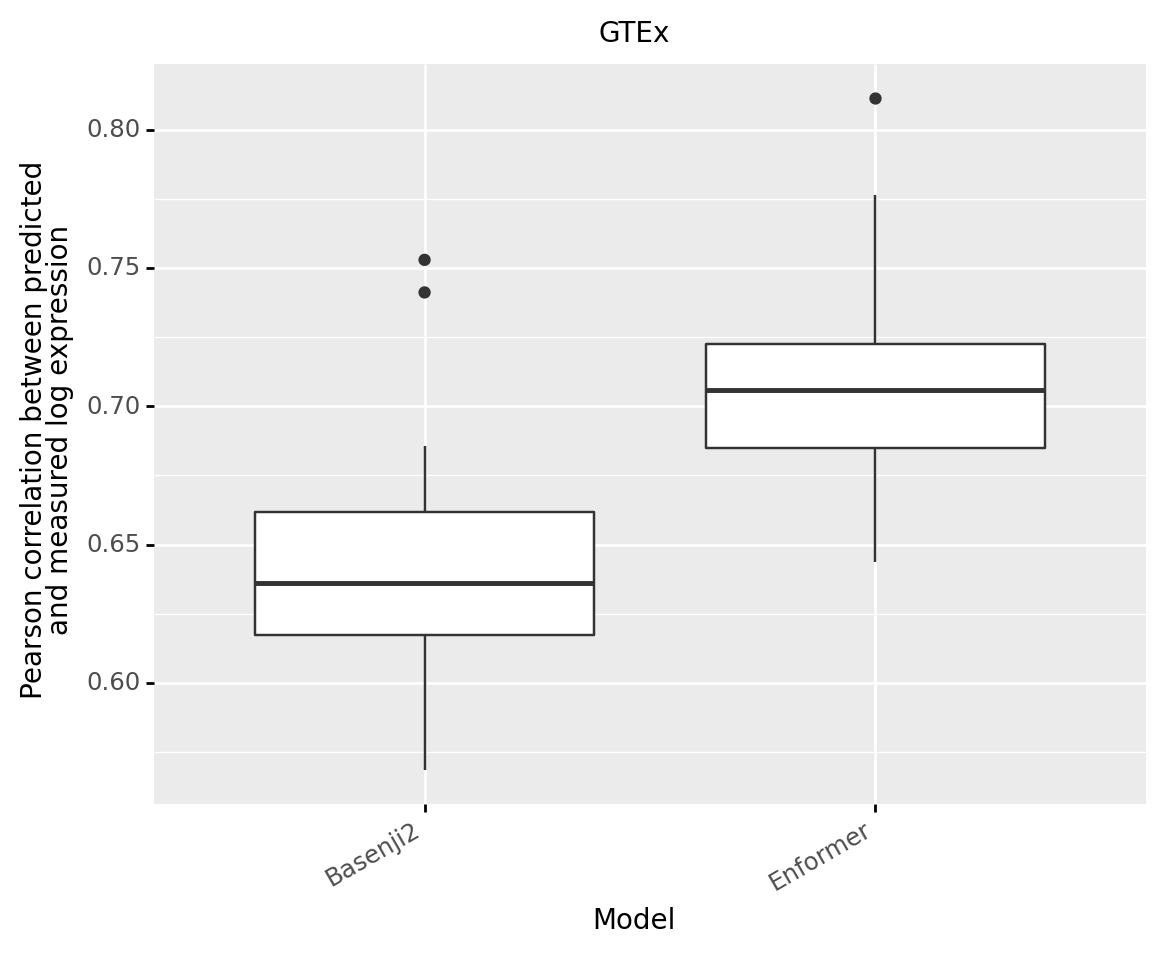

<ggplot: (1422615737947)>

In [22]:
scale = 1
p9.options.figure_size = (6.4*scale, 4.8*scale)

gtex_corrs["model_cat"] = pd.Categorical(gtex_corrs["model"],
                                             categories=["Basenji2", "Enformer"])

p = (p9.ggplot(data=gtex_corrs,mapping=p9.aes(x="model_cat",y="r"))
 + p9.geom_boxplot()
 + p9.labs(x="Model",y="Pearson correlation between predicted\nand measured log expression", title="GTEx")
 + p9.theme(axis_title=p9.element_text(size=10), title=p9.element_text(size=10),
           axis_text_x=p9.element_text(rotation=30, hjust=1))
)
p

In [23]:
p.save("Graphics/" + "xsup_manual_match_gtex" + ".png", width=6.4, height=4.8, dpi=300)

/opt/modules/i12g/anaconda/envs/karollus-tfhub/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/modules/i12g/anaconda/envs/karollus-tfhub/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: Graphics/xsup_manual_match_gtex.png


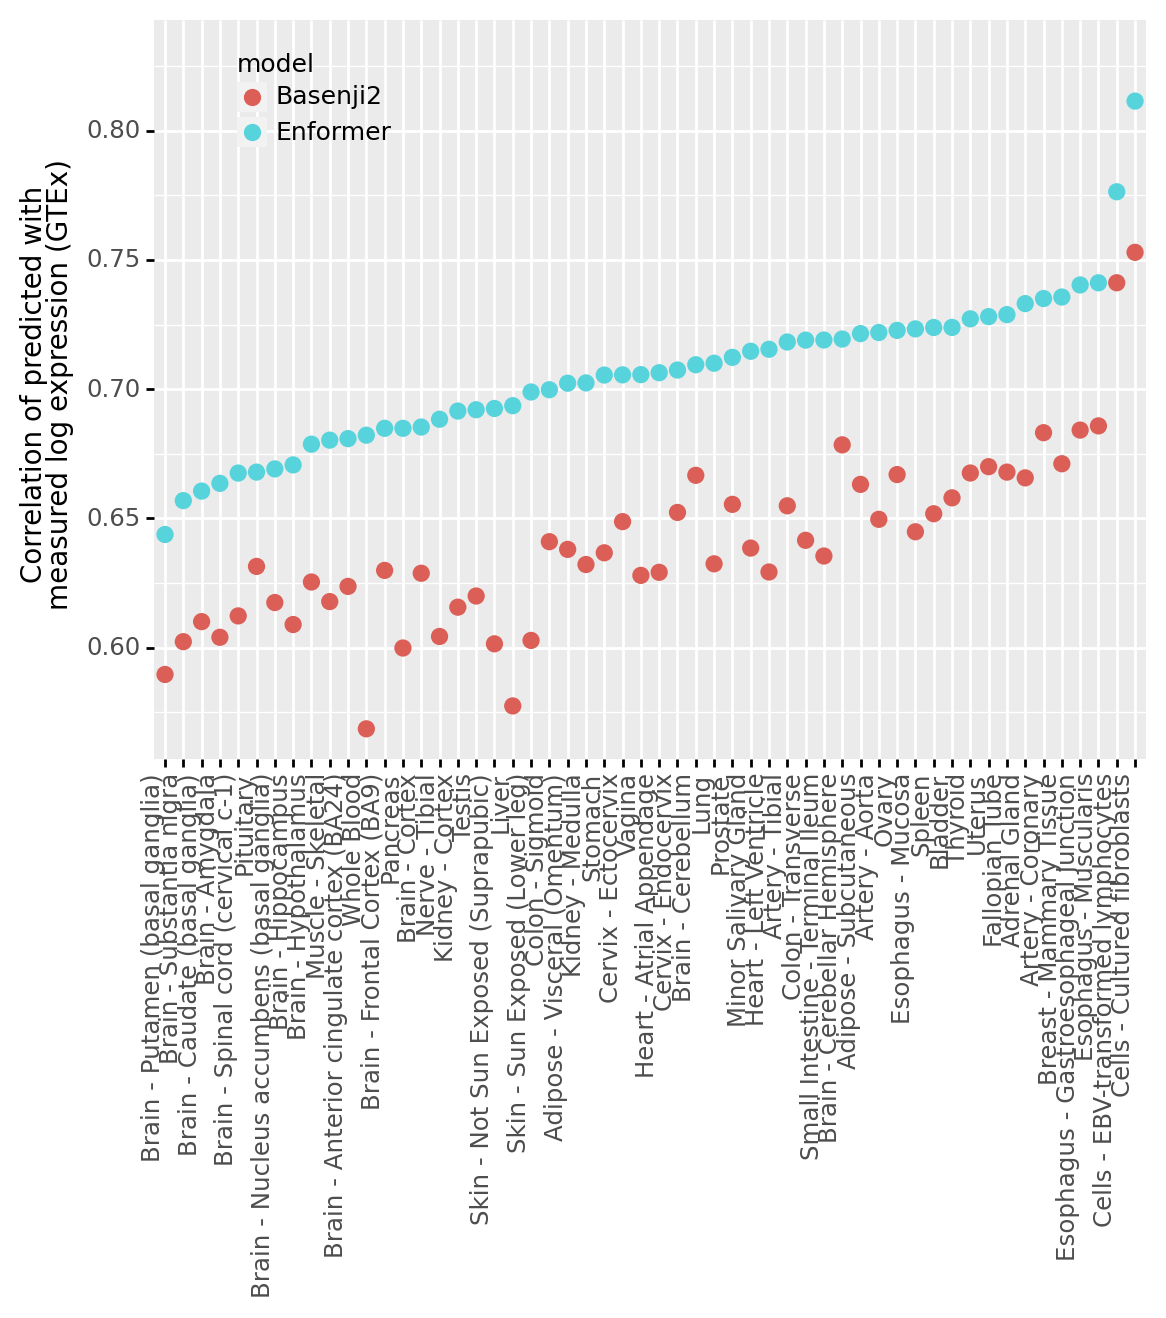

<ggplot: (1422514887241)>

In [48]:
scale = 1
p9.options.figure_size = (6.4*scale, 4.8*scale)

plot_df = gtex_corrs.query('model in ["Basenji2","Enformer"]')
plot_df["tissue_cat"] = pd.Categorical(plot_df['tissue'],
                                       plot_df.query('model == "Enformer"').sort_values('r')['tissue'])

p = (p9.ggplot(data=plot_df,mapping=p9.aes(x="tissue_cat",y="r",color="model"))
 #+ p9.geom_col(position="dodge")
 + p9.geom_point(size=2.5)
 + p9.coords.coord_cartesian(ylim=(0.57,0.83))
 + p9.labs(x="",y="Correlation of predicted with\nmeasured log expression (GTEx)")
 + p9.theme(axis_title=p9.element_text(size=10),
           axis_text_x=p9.element_text(rotation=90, hjust=1),
           legend_box_margin=0, legend_key_size=9, 
            legend_text=p9.element_text(size=9),
            legend_background=p9.element_blank(),
            legend_title=p9.element_text(size=9), legend_position=(0.25,0.8))
)
p

In [27]:
p.save("Graphics/" + "xsup_manual_gtex_tissues" + ".png", width=7.2, height=4.8, dpi=300)

/opt/modules/i12g/anaconda/envs/karollus-tfhub/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7.2 x 4.8 in image.
/opt/modules/i12g/anaconda/envs/karollus-tfhub/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: Graphics/xsup_manual_gtex_tissues.png


In [50]:
enformer_gtex_modelmatched_corrs = pd.read_csv(base_path_results + "gtex_corrs_modelmatched_enformer.tsv", sep="\t")[["tissue","r", "window_size"]].query('window_size == "Full"')

In [54]:
compare_df = gtex_corrs.query('model == "Enformer"')[['tissue','r']].merge(enformer_gtex_modelmatched_corrs[['tissue','r']], on='tissue')

In [55]:
scipy.stats.spearmanr(compare_df['r_x'],compare_df['r_y'])

SpearmanrResult(correlation=0.7430150562226033, pvalue=1.2473168520783197e-10)

## GTEX - Between tissues

In [28]:
tissue_pred_df = (pd.read_csv(base_path_results + "gtex_pred_manualmatched_enformer.tsv", sep="\t")
                  [["gene_id","tissue","log_obs","log_pred_ingenome","expressed"]]
                  .rename(columns={"log_pred_ingenome":"log_pred_enformer"})
                 )
tissue_pred_df_basenji2 = (pd.read_csv(base_path_results + "gtex_pred_manualmatched_basenji2.tsv", sep="\t")
                          [["gene_id","tissue","log_pred_basenji2"]]
                         )
tissue_pred_df = (tissue_pred_df
                  .merge(tissue_pred_df_basenji2, on=["gene_id", "tissue"])
                 )

In [29]:
tissue_var_df_molten = tissue_pred_df

In [30]:
rows = []

tissue_var_df_molten_indexed = tissue_var_df_molten.set_index("gene_id")
for gene in set(tissue_var_df_molten.query('gene_id in @test_genes')["gene_id"]):
    subset = tissue_var_df_molten_indexed.loc[gene]
    for col in [x for x in subset.keys() if x.startswith("log_pred")]:
        row_dict = {"gene_id":gene}
        row_dict["model"] = col.split("_")[-1]
        tpl = (subset["log_obs"],subset[col])
        corr_test =  scipy.stats.pearsonr(*tpl)
        r = corr_test[0]
        row_dict["R"] = r
        row_dict["p"] = corr_test[1]
        row_dict["rho"] = scipy.stats.spearmanr(*tpl)[0]
        row_dict["R-squared"]  = sklearn.metrics.r2_score(*tpl)
        row_dict["pred_mean_log_expr_enformer"] = subset["log_pred_enformer"].mean()
        row_dict["pred_std_log_expr_enformer"] = subset["log_pred_enformer"].std()
        row_dict["pred_mean_log_expr_basenji2"] = subset["log_pred_basenji2"].mean()
        row_dict["pred_std_log_expr_basenji2"] = subset["log_pred_basenji2"].std()
        row_dict["mean_log_expr"] = subset["log_obs"].mean()
        row_dict["std_log_expr"] = subset["log_obs"].std()
        row_dict["mae_log_expr"] = np.abs(subset["log_obs"] - subset["log_obs"].mean()).mean()
        row_dict["dyn_range_log_expr"] = subset["log_obs"].quantile([0.05,0.95]).max() - subset["log_obs"].quantile([0.05,0.95]).min()
        rows.append(row_dict)
        
between_tissue_corrs = pd.DataFrame(rows)

In [31]:
gene_mean_df = (between_tissue_corrs
           .groupby('gene_id')
           [["pred_mean_log_expr_enformer","pred_std_log_expr_enformer","pred_mean_log_expr_basenji2","pred_std_log_expr_basenji2","mean_log_expr" ,"std_log_expr"]]
           .mean()
           .reset_index()
          )
# prediction of gene mean
print(scipy.stats.pearsonr(gene_mean_df["mean_log_expr"],gene_mean_df["pred_mean_log_expr_basenji2"]))
print(scipy.stats.pearsonr(gene_mean_df["mean_log_expr"],gene_mean_df["pred_mean_log_expr_enformer"]))
# prediction of gene standard deviation
print(scipy.stats.pearsonr(gene_mean_df["std_log_expr"],gene_mean_df["pred_std_log_expr_basenji2"]))
print(scipy.stats.pearsonr(gene_mean_df["std_log_expr"],gene_mean_df["pred_std_log_expr_enformer"]))

(0.6870913137644379, 8.315651196213907e-199)
(0.7497290763356315, 2.342178466518381e-256)
(0.4742470498616209, 1.798901205560912e-80)
(0.598091945718725, 2.110986046300726e-138)


In [32]:
sklearn.metrics.r2_score(tissue_pred_df.query('gene_id in @test_genes')["log_obs"],
                         tissue_pred_df.query('gene_id in @test_genes')["log_pred_enformer"])

0.3411621084355805

In [33]:
gene_dev_df = tissue_pred_df.merge(gene_mean_df, on="gene_id")

In [34]:
gene_dev_df["condition"] = gene_dev_df["log_obs"] - gene_dev_df['mean_log_expr']

gene_dev_df['log2_fc'] = gene_dev_df['condition']/np.log10(2)
gene_dev_df['pred_log2_fc'] = (gene_dev_df['log_pred_enformer'] - gene_dev_df['pred_mean_log_expr_enformer'])/np.log10(2)
gene_dev_df['pred_log2_fc_basenji2'] = (gene_dev_df['log_pred_basenji2'] - gene_dev_df['pred_mean_log_expr_basenji2'])/np.log10(2)
gene_dev_df["abs_log2_fc"] = np.abs(gene_dev_df["log2_fc"])
gene_dev_df["abs_pred_log2_fc"] = np.abs(gene_dev_df["pred_log2_fc"])

In [35]:
print(scipy.stats.pearsonr(gene_dev_df['log2_fc'], gene_dev_df['pred_log2_fc']))
print(scipy.stats.pearsonr(gene_dev_df['log2_fc'], gene_dev_df['pred_log2_fc_basenji2']))

(0.4218120814517516, 0.0)
(0.3359412890973684, 0.0)


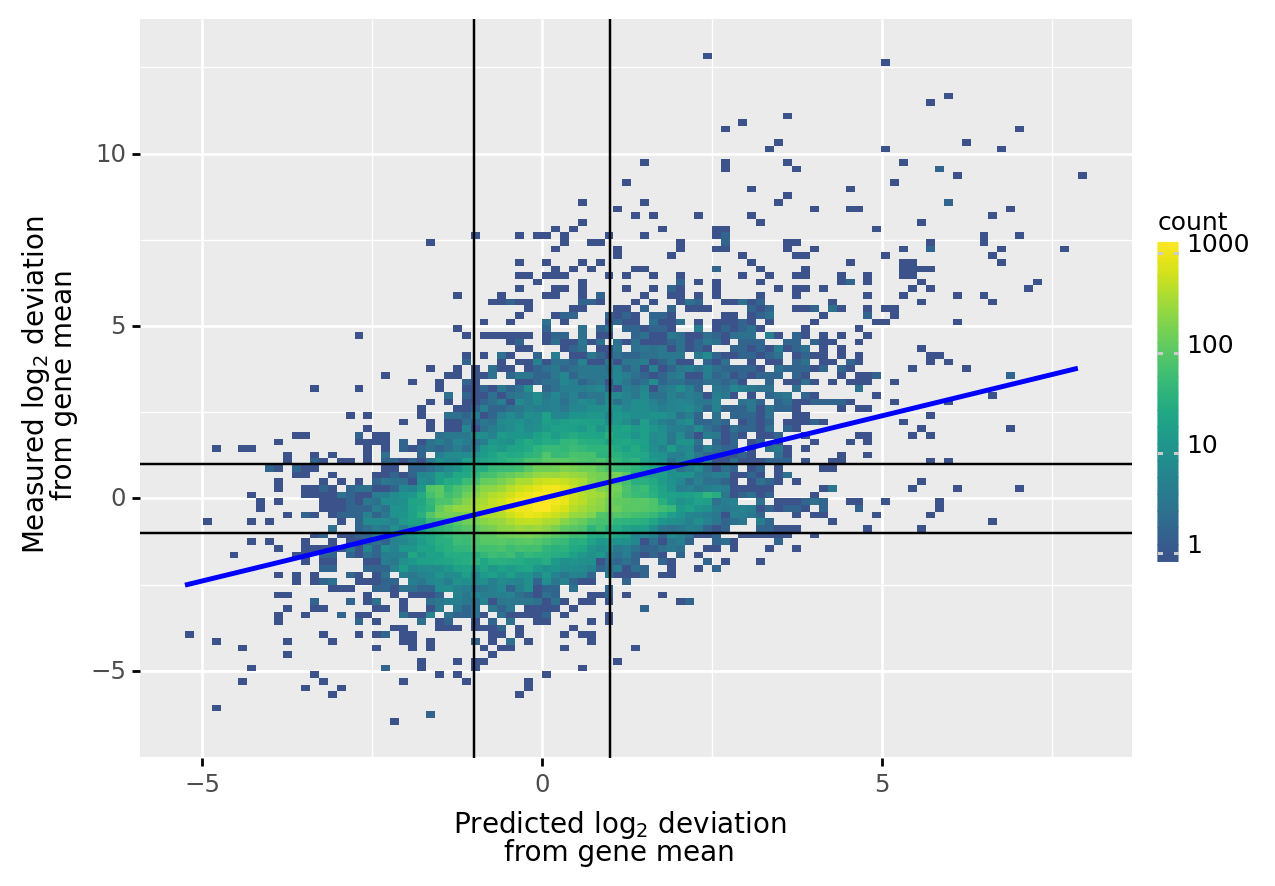

<ggplot: (1422515559885)>

In [36]:
scale = 1
p9.options.figure_size = (6.4*scale, 4.8*scale)

p = (p9.ggplot(data=gene_dev_df,mapping=p9.aes(x="pred_log2_fc",y="log2_fc",))
 #+ p9.geom_col(position="dodge")
 + p9.geom_bin2d(bins=100, raster=True)
 + p9.scale_fill_continuous(ListedColormap(cm.get_cmap('viridis', 512)(np.linspace(0.25, 1, 512))), trans="log10")
 + p9.geom_smooth(method="lm",color="blue")
 + p9.geom_vline(xintercept = 1)
 + p9.geom_vline(xintercept = -1)
 + p9.geom_hline(yintercept = 1)
 + p9.geom_hline(yintercept = -1)
 + p9.labs(x="Predicted $\mathregular{log_2}$ deviation\nfrom gene mean",y="Measured $\mathregular{log_2}$ deviation\nfrom gene mean")
 + p9.theme(legend_text=p9.element_text(size=9),legend_title=p9.element_text(size=9),
            legend_box_margin=0,legend_key_width=5,axis_title=p9.element_text(size=10))#
 #+ p9.scale_y_log10()
 #+ p9.labs(x="",y="Density")
)
p

In [37]:
p.save("Graphics/" + "xsup_manual_gtex_between" + ".png", width=6.4, height=4.8, dpi=300)

/opt/modules/i12g/anaconda/envs/karollus-tfhub/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/modules/i12g/anaconda/envs/karollus-tfhub/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: Graphics/xsup_manual_gtex_between.png


In [49]:
classify_df = gene_dev_df.copy()
classify_df["differential"] = classify_df['abs_log2_fc'] > 1
classify_df["pred_differential"] = classify_df['abs_pred_log2_fc'] > 1.15

classify_rows_gtex = []
classify_rows_gtex.append({"Dataset":"GTEx","Metric":"FPR","Score":np.sum(classify_df["pred_differential"])/np.sum(~classify_df["differential"])})
classify_rows_gtex.append({"Dataset":"GTEx","Metric":"Precision","Score":sklearn.metrics.precision_score(classify_df["differential"], classify_df["pred_differential"])})
classify_rows_gtex.append({"Dataset":"GTEx","Metric":"Recall","Score":sklearn.metrics.recall_score(classify_df["differential"], classify_df["pred_differential"])})
classify_rows_gtex.append({"Dataset":"GTEx","Metric":"MCC","Score":sklearn.metrics.matthews_corrcoef(classify_df["differential"], classify_df["pred_differential"])})
classify_rows_gtex.append({"Dataset":"GTEx","Metric":"Prevalence","Score":np.sum(classify_df["differential"])/len(classify_df["differential"])})
pd.DataFrame(classify_rows_gtex)

,Dataset,Metric,Score
0,GTEx,FPR,0.166610
1,GTEx,Precision,0.344615
2,GTEx,Recall,0.296588
3,GTEx,MCC,0.199327
4,GTEx,Prevalence,0.162190


## Kaessmann - Between genes

In [38]:
enformer_kaessmann_corrs = pd.read_csv(base_path_results + "kaessmann_corrs_manualmatched_enformer.tsv", sep="\t")[["sample","r", "window_size"]]
enformer_kaessmann_corrs["model"] = "Enformer"
enformer_kaessmann_corrs.query('window_size == "Full"').median()

/scratch/tmp/karollus/ipykernel_2325407/546196250.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


r    0.691088
dtype: float64

In [39]:
basenji2_kaessmann_corrs = pd.read_csv(base_path_results + "kaessmann_corrs_manualmatched_basenji2.tsv", sep="\t")[["sample","r"]]
basenji2_kaessmann_corrs["model"] = "Basenji2"
basenji2_kaessmann_corrs.median()

/scratch/tmp/karollus/ipykernel_2325407/2471711924.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


r    0.642293
dtype: float64

In [40]:
combined_corrs = pd.concat([enformer_kaessmann_corrs.query('window_size == "Full"')[["sample","r","model"]], basenji2_kaessmann_corrs])

In [41]:
combined_corrs["tissue"] = combined_corrs["sample"].apply(lambda x: x.split('.')[0])
combined_corrs["stage"] = combined_corrs["sample"].apply(lambda x: x.split('.')[1].lower())
combined_corrs["stage_num"] = combined_corrs["sample"].apply(lambda x: int(x.split('.')[2]))

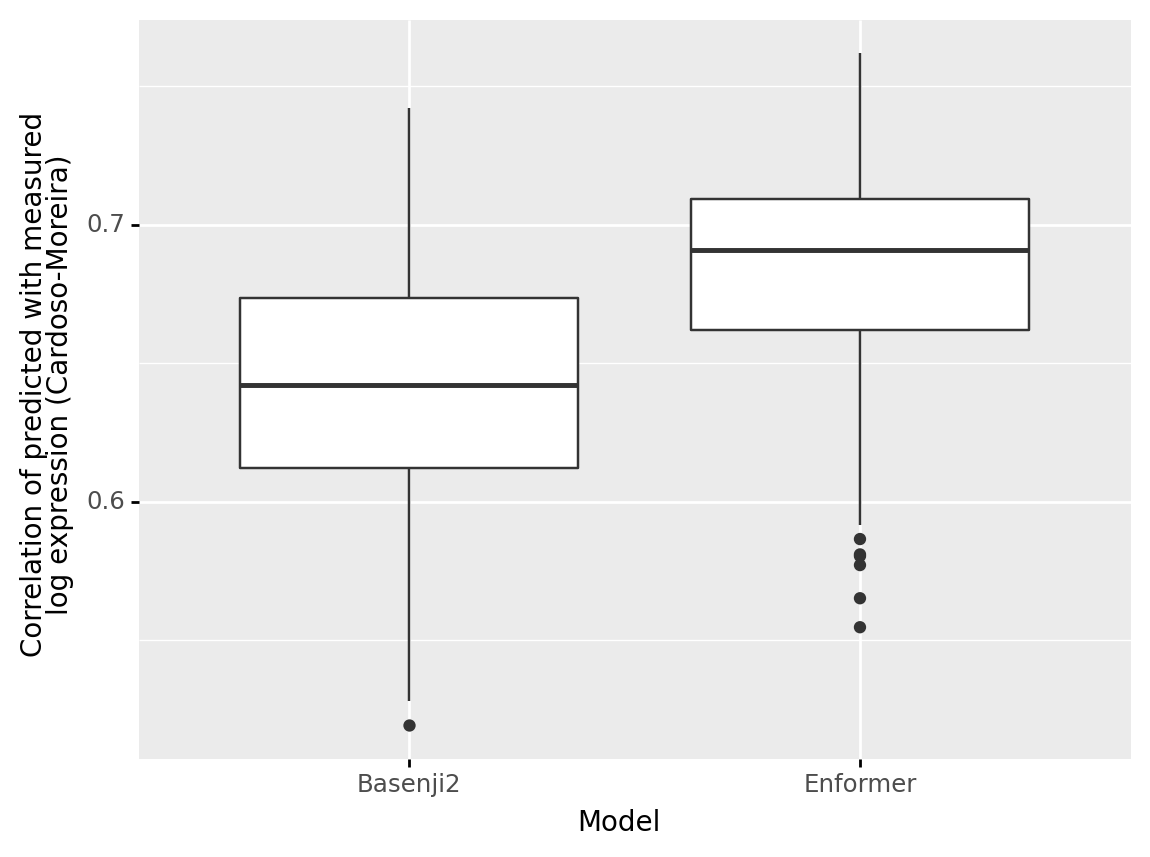

<ggplot: (1422515400445)>

In [42]:
scale = 1
p9.options.figure_size = (6.4*scale, 4.8*scale)

combined_corrs["model_cat"] = pd.Categorical(combined_corrs["model"],
                                             categories=["Basenji2", "Enformer"])

p = (p9.ggplot(data=combined_corrs
           ,mapping=p9.aes(x="model_cat",y="r"))
 + p9.geom_boxplot()
 + p9.labs(x="Model",y="Correlation of predicted with measured\nlog expression (Cardoso-Moreira)")
 + p9.theme(axis_title=p9.element_text(size=10))
)
p

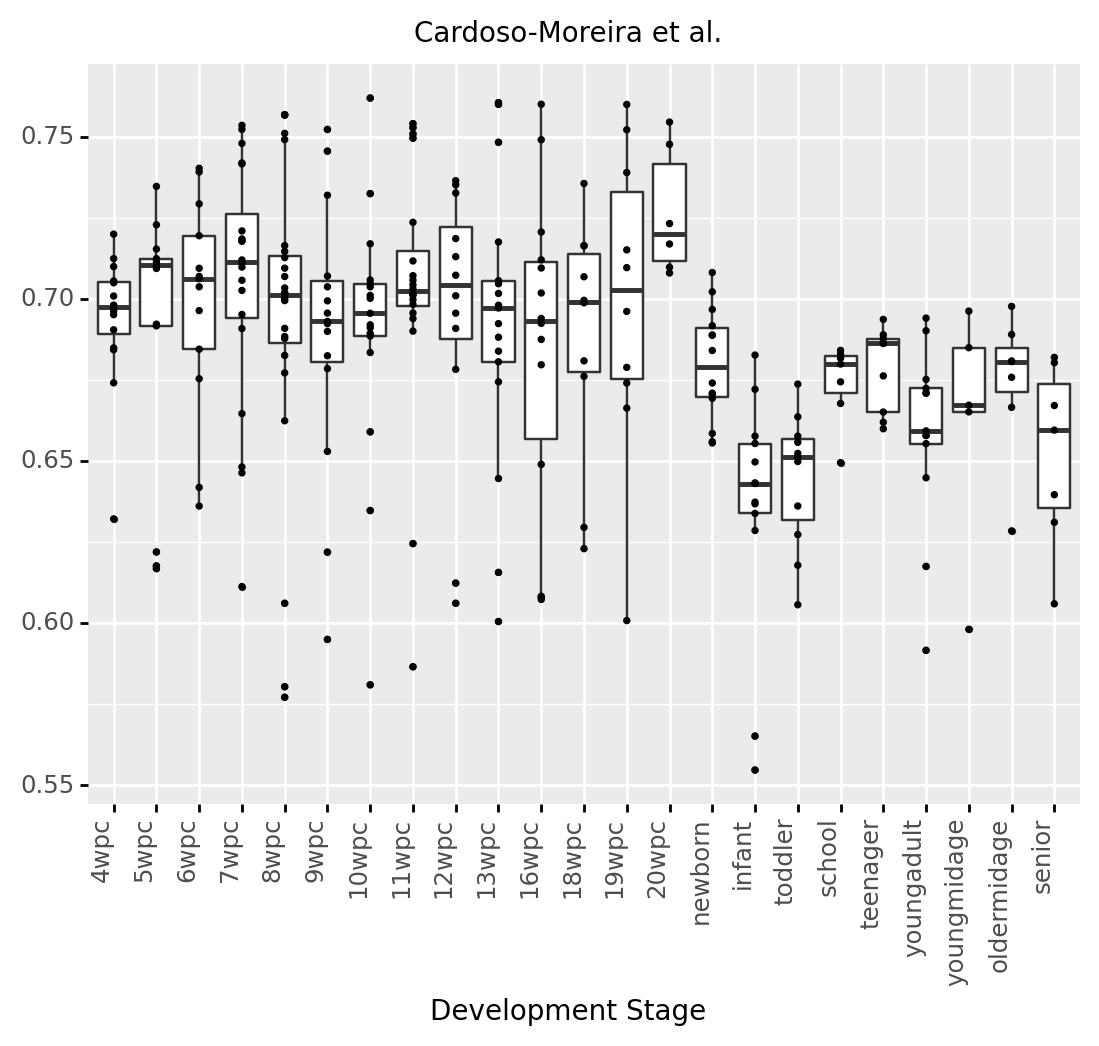

<ggplot: (1422515306999)>

In [45]:
stage_cats = ['4wpc','5wpc','6wpc','7wpc','8wpc','9wpc','10wpc','11wpc','12wpc','13wpc','16wpc','18wpc','19wpc','20wpc','newborn','infant','toddler',
              'school','youngteenager','teenager','oldteenager','youngadult','youngmidage','oldermidage','senior']

plot_df = combined_corrs.query('model in ["Enformer"]')



scale = 1.0
p9.options.figure_size = (6.4*scale, 4.8*scale)


plot_df = plot_df.query('stage not in ["youngteenager","oldteenager"]')
plot_df["stage"] = pd.Categorical(plot_df["stage"],
                                     categories=stage_cats)

p = (p9.ggplot(data=plot_df
           ,mapping=p9.aes(x="stage",y="r"))
 #+ p9.geom_col(position="dodge")
 + p9.geom_boxplot(outlier_size=0.5)
 + p9.geom_point(size=0.5)
 #+ p9.coords.coord_cartesian(ylim=(0.7,0.84))
 + p9.labs(x="Development Stage",y="", title="Cardoso-Moreira et al.")
 + p9.theme(axis_title=p9.element_text(size=10), title=p9.element_text(size=10),
            legend_background=p9.element_blank(),
            legend_text=p9.element_text(size=8),legend_key_size=8,
            legend_title=p9.element_text(size=8), axis_text_x=p9.element_text(rotation=90, hjust=1))
)
p

In [46]:
p.save("Graphics/" + "xsup_manual_kaessmann_stages" + ".png", width=6.4, height=4.8, dpi=300)

/opt/modules/i12g/anaconda/envs/karollus-tfhub/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/modules/i12g/anaconda/envs/karollus-tfhub/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: Graphics/xsup_manual_kaessmann_stages.png


## Kaessmann - Between samples

In [22]:
kaessmann_tissues = set([x.split(".")[0] for x in dev_tissues])

kaessmann_pred_df = (pd.read_csv(base_path_results + "kaessmann_pred_manualmatched_enformer.tsv", sep="\t")
                  [["gene_id","sample","log_obs","log_pred_ingenome"]]
                  .rename(columns={"log_pred_ingenome":"log_pred_enformer"})
                 )

kaessmann_pred_df_basenji2 = (pd.read_csv(base_path_results + "kaessmann_pred_manualmatched_basenji2.tsv", sep="\t")
                          [["gene_id","sample","log_pred_basenji2"]]
                         )

kaessmann_pred_df = (kaessmann_pred_df
                  .merge(kaessmann_pred_df_basenji2, on=["gene_id", "sample"])
                 )

In [23]:
dev_var_df = kaessmann_pred_df

dev_var_df["tissue"] = dev_var_df["sample"].apply(lambda x: x.split(".")[0])
dev_var_df["dev_stage"] = dev_var_df["sample"].apply(lambda x: "_".join(x.split("_")[0].split(".")[1:]))
dev_var_df["dev_stage_number"] = dev_var_df["dev_stage"].apply(lambda x: int(x.split("_")[1]))
dev_var_df["dev_stage"] = dev_var_df["dev_stage"].apply(lambda x: x.split("_")[0])

dev_var_df_aggreg = dev_var_df.groupby(["gene_id","tissue","dev_stage"]).mean().reset_index()

In [ ]:
rows = []

dev_var_df_indexed = dev_var_df_aggreg.set_index("gene_id")

for tissue in kaessmann_tissues:
    tissue_subset_df = dev_var_df_indexed.query('tissue == @tissue')
    for gene in set(tissue_subset_df.index[tissue_subset_df.index.isin(test_genes)]):
        subset = tissue_subset_df.loc[gene]
        # skip genes which are constant across dev-stages (or never expressed)
        if not (subset["log_obs"].std() > 0):
            continue
        for col in [x for x in subset.keys() if x.startswith("log_pred")]:
            row_dict = {"gene_id":gene}
            row_dict["model"] = col.split("_")[-1]
            row_dict["tissue"] = tissue
            tpl = (subset["log_obs"],subset[col])
            corr_test =  scipy.stats.pearsonr(*tpl)
            r = corr_test[0]
            row_dict["R"] = r
            row_dict["p"] = corr_test[1]
            row_dict["rho"] = scipy.stats.spearmanr(*tpl)[0]
            row_dict["R-squared"]  = sklearn.metrics.r2_score(*tpl)
            row_dict["pred_mean_log_expr_enformer"] = subset["log_pred_enformer"].mean()
            row_dict["pred_std_log_expr_enformer"] = subset["log_pred_enformer"].std()
            row_dict["pred_mean_log_expr_basenji2"] = subset["log_pred_basenji2"].mean()
            row_dict["pred_std_log_expr_basenji2"] = subset["log_pred_basenji2"].std()
            row_dict["mean_log_expr"] = subset["log_obs"].mean()
            row_dict["std_log_expr"] = subset["log_obs"].std()
            rows.append(row_dict)
        
between_dev_corrs = pd.DataFrame(rows)

In [25]:
gene_mean_df = (between_dev_corrs
           .groupby('gene_id')
           [["pred_mean_log_expr_enformer","pred_std_log_expr_enformer","pred_mean_log_expr_basenji2","pred_std_log_expr_basenji2","mean_log_expr" ,"std_log_expr"]]
           .mean()
           .reset_index()
          )
# prediction of gene mean
print(scipy.stats.pearsonr(gene_mean_df["mean_log_expr"],gene_mean_df["pred_mean_log_expr_basenji2"]))
print(scipy.stats.pearsonr(gene_mean_df["mean_log_expr"],gene_mean_df["pred_mean_log_expr_enformer"]))
# prediction of gene standard deviation
print(scipy.stats.pearsonr(gene_mean_df["std_log_expr"],gene_mean_df["pred_std_log_expr_basenji2"]))
print(scipy.stats.pearsonr(gene_mean_df["std_log_expr"],gene_mean_df["pred_std_log_expr_enformer"]))

(0.7047161887591151, 2.275362564153913e-211)
(0.740391443068654, 2.613525085185607e-244)
(-0.3777642809375574, 6.916265608340385e-49)
(-0.2585818147997015, 6.725454454001534e-23)


In [26]:
gene_dev_df = dev_var_df_aggreg.merge(gene_mean_df, on="gene_id")

In [28]:
gene_dev_df 

,gene_id,tissue,dev_stage,log_obs,log_pred_enformer,log_pred_basenji2,dev_stage_number,pred_mean_log_expr_enformer,pred_std_log_expr_enformer,pred_mean_log_expr_basenji2,pred_std_log_expr_basenji2,mean_log_expr,std_log_expr
0,ENSG00000004776,Brain,10wpc,-0.176226,0.057227,-0.372524,16.0,0.335470,0.063720,-0.027715,0.028481,0.382943,0.315678
1,ENSG00000004776,Brain,11wpc,-0.188755,0.057227,-0.372524,18.5,0.335470,0.063720,-0.027715,0.028481,0.382943,0.315678
2,ENSG00000004776,Brain,12wpc,-0.460609,0.057227,-0.372524,21.0,0.335470,0.063720,-0.027715,0.028481,0.382943,0.315678
3,ENSG00000004776,Brain,13wpc,-0.387005,0.057227,-0.372524,23.0,0.335470,0.063720,-0.027715,0.028481,0.382943,0.315678
4,ENSG00000004776,Brain,16wpc,-0.411204,0.057227,-0.372524,25.5,0.335470,0.063720,-0.027715,0.028481,0.382943,0.315678
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188265,ENSG00000273173,Testis,olderMidAge,-0.633944,0.622998,0.140282,40.0,0.808182,0.031524,0.253899,0.034800,-0.525667,0.053510
188266,ENSG00000273173,Testis,toddler,-0.456625,0.622998,0.140282,31.0,0.808182,0.031524,0.253899,0.034800,-0.525667,0.053510
188267,ENSG00000273173,Testis,youngAdult,-0.595383,0.622998,0.140282,37.0,0.808182,0.031524,0.253899,0.034800,-0.525667,0.053510
188268,ENSG00000273173,Testis,youngMidAge,-0.598957,0.622998,0.140282,39.0,0.808182,0.031524,0.253899,0.034800,-0.525667,0.053510


In [29]:
gene_dev_df["condition"] = gene_dev_df["log_obs"] - gene_dev_df['mean_log_expr']

gene_dev_df['log2_fc'] = gene_dev_df['condition']/np.log10(2)
gene_dev_df['pred_log2_fc'] = (gene_dev_df['log_pred_enformer'] - gene_dev_df['pred_mean_log_expr_enformer'])/np.log10(2)
gene_dev_df['pred_log2_fc_basenji2'] = (gene_dev_df['log_pred_basenji2'] - gene_dev_df['pred_mean_log_expr_basenji2'])/np.log10(2)
gene_dev_df["abs_log2_fc"] = np.abs(gene_dev_df["log2_fc"])
gene_dev_df["abs_pred_log2_fc"] = np.abs(gene_dev_df["pred_log2_fc"])

In [30]:
print(scipy.stats.pearsonr(gene_dev_df['log2_fc'], gene_dev_df['pred_log2_fc_basenji2']))
print(scipy.stats.pearsonr(gene_dev_df['log2_fc'], gene_dev_df['pred_log2_fc']))

(0.3007632572581953, 0.0)
(0.3848346691798924, 0.0)


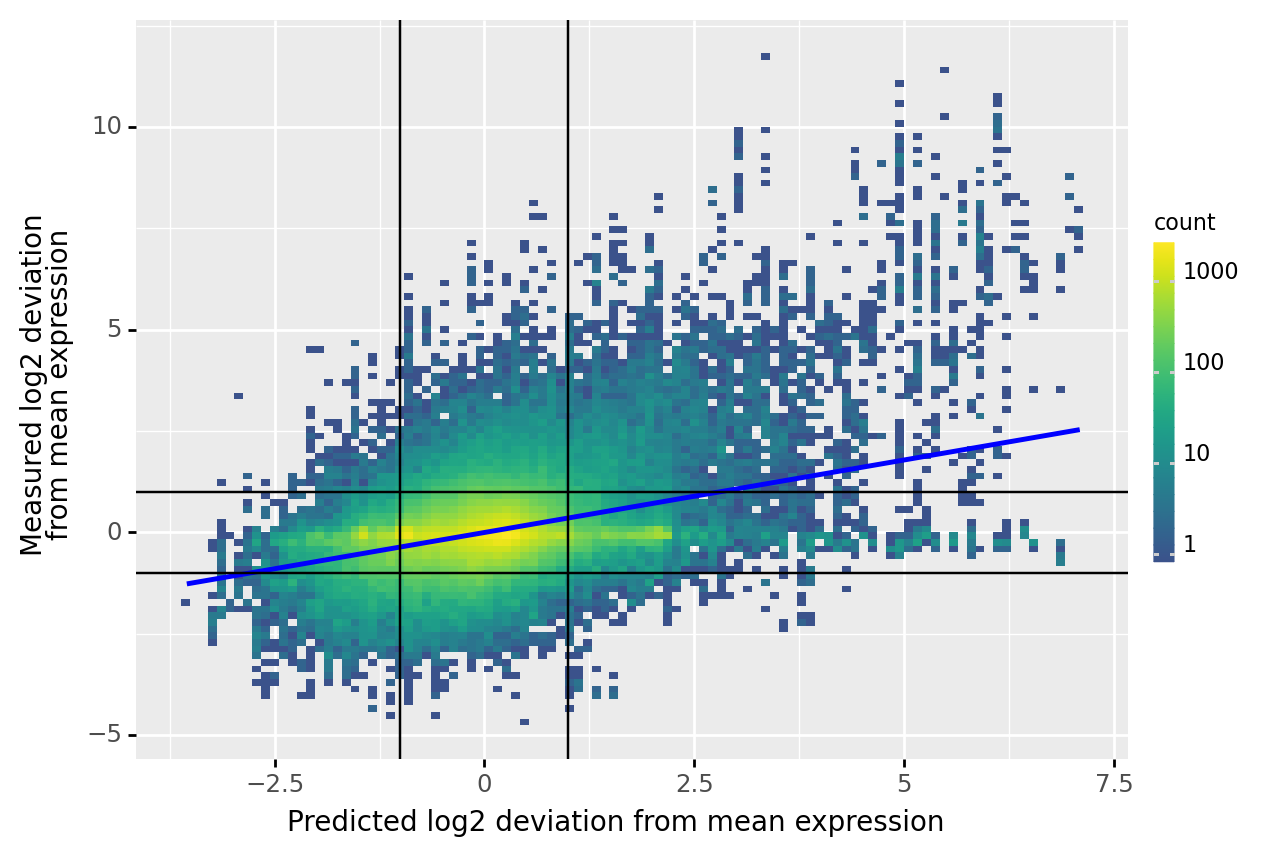

<ggplot: (1431200202132)>

In [31]:
scale = 1
p9.options.figure_size = (6.4*scale, 4.8*scale)

p = (p9.ggplot(data=gene_dev_df,mapping=p9.aes(x="pred_log2_fc",y="log2_fc",))
 #+ p9.geom_col(position="dodge")
 + p9.geom_bin2d(bins=100, raster=True)
 + p9.scale_fill_continuous(ListedColormap(cm.get_cmap('viridis', 512)(np.linspace(0.25, 1, 512))), trans="log10")
 + p9.geom_smooth(method="lm",color="blue")
 + p9.geom_vline(xintercept = 1)
 + p9.geom_vline(xintercept = -1)
 + p9.geom_hline(yintercept = 1)
 + p9.geom_hline(yintercept = -1)
 + p9.theme(legend_text=p9.element_text(size=8),legend_title=p9.element_text(size=8),
            legend_box_margin=0,legend_key_width=5,axis_title=p9.element_text(size=10))#
 + p9.labs(x="Predicted log2 deviation from mean expression",y="Measured log2 deviation\nfrom mean expression")
 #+ p9.scale_y_log10()
 #+ p9.labs(x="",y="Density")
)
p